# Try CellChat pipeline on the downsampled dataset (5k)

In [1]:
suppressPackageStartupMessages({
    library(Seurat)
    library(CellChat)
    library(repr)
    library(patchwork)
    library(tidyverse)
    library(ggplot2)
    library(pheatmap)
    library(Matrix)
})
options(future.globals.maxSize = Inf)
options(Seurat.object.assay.version = "v5")
options(ggrepel.max.overlaps = Inf)

In [2]:
setwd("/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/all/")

## Create Seurat Object

In [3]:
count_matrix <- readMM("BICCN_5K_rna.mtx")
meta_data <- read.table("BICCN_5K_meta.tsv", header = TRUE, sep = "\t", row.names = 1)
gene_names <- read.table("BICCN_5K_gene.tsv", header = FALSE, sep = "\t")
barcode_names <- read.table("BICCN_5K_barcodes.tsv", header = FALSE, sep = "\t")

In [4]:
rownames(count_matrix) <- gene_names$V1
colnames(count_matrix) <- barcode_names$V1
count_matrix <- as(count_matrix, "dgCMatrix")

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [5]:
BICCN_5k_Object <- CreateSeuratObject(counts = count_matrix, meta.data = meta_data)
BICCN_5k_Object <- NormalizeData(BICCN_5k_Object, verbose = FALSE)

In [6]:
BICCN_5k_Object

An object of class Seurat 
32876 features across 113924 samples within 1 assay 
Active assay: RNA (32876 features, 0 variable features)
 2 layers present: counts, data

In [7]:
saveRDS(BICCN_5k_Object, "BICCN_5K_rna.rds")

## Start CellChat pipeline

In [3]:
BICCN_5k_Object <- readRDS("BICCN_5K_rna.rds")

In [4]:
BICCN_5k_Object$label <- BICCN_5k_Object$Subclass_F
BICCN_5k_Object$label[BICCN_5k_Object$Subclass_F == "L4 IT"] <- paste(
    "L4_IT", 
    BICCN_5k_Object$Region[BICCN_5k_Object$Subclass_F == "L4 IT"],
    sep = "-"
)

In [5]:
data_input <- BICCN_5k_Object[["RNA"]]$data
labels <- BICCN_5k_Object$label
meta <- data.frame(labels = labels, row.names = names(labels))

In [6]:
cellchat <- createCellChat(object = data_input, meta = meta, group.by = "labels")

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Astro Chandelier Endo L2/3 IT L4_IT-A1C L4_IT-A24 L4_IT-A9 L4_IT-AnG L4_IT-FI L4_IT-M1C L4_IT-MTG L4_IT-S1C L4_IT-V1C L5 ET L5 IT L5/6 NP L6 CT L6 IT L6 IT Car3 L6B LAMP5 LAMP5 LHX6 Micro/PVM Oligo OPC PAX6 PVALB SNCG SST SST CHODL VIP VLMC 


In [7]:
cellchat@DB <- CellChatDB.human

In [8]:
cellchat <- subsetData(cellchat)
future::plan("multisession", workers = 12)
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)

In [9]:
cellchat <- computeCommunProb(cellchat, type = "triMean")

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-08-21 18:48:57.678949]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-08-21 19:58:09.810293]"


In [10]:
saveRDS(cellchat, "cellchat/BICCN_5K_cellchat_obj.rds")

### Some basic metrics

In [3]:
cellchat <- readRDS("cellchat//BICCN_5K_cellchat_obj.rds")

In [4]:
cellchat <- filterCommunication(cellchat, min.cells = 10)

In [5]:
ident_levels <- c(
    "Oligo", "Astro", "Micro/PVM", "OPC", "Endo", "VLMC",
    "L2/3 IT", "L4_IT-A24", "L4_IT-A9", "L4_IT-FI", "L4_IT-M1C",
    "L4_IT-S1C", "L4_IT-MTG", "L4_IT-A1C", "L4_IT-AnG", "L4_IT-V1C",
    "L5 IT", "L5/6 NP", "L5 ET" , "L6 IT", "L6 IT Car3", "L6 CT", "L6B",
    "LAMP5", "LAMP5 LHX6", "SST", "SST CHODL", "PVALB", "Chandelier",
    "PAX6", "SNCG", "VIP"
)
# cellchat@idents <- factor(cellchat@idents, levels = ident_levels)

In [6]:
## Data frame level of communication
df_net <- subsetCommunication(cellchat, slot.name = "netP")

In [7]:
unique(df_net$pathway_name)

[1] "BMP"          "CADM"         "CDH"          "FGF"          "LAMININ"     
 [6] "NCAM"         "NRG"          "PTN"          "CNTN"         "EPHA"        
[11] "NGL"          "NRXN"         "PDGF"         "PTPRM"        "TGFb"        
[16] "COLLAGEN"     "FN1"          "GAS"          "NECTIN"       "NEGR"        
[21] "TENASCIN"     "CRH"          "KIT"          "APP"          "CD46"        
[26] "VISFATIN"     "PECAM1"       "PARs"         "JAM"          "SEMA3"       
[31] "AGRN"         "L1CAM"        "PROS"         "SEMA5"        "SEMA6"       
[36] "MPZ"          "CCK"          "SEMA4"        "EGF"          "EPHB"        
[41] "THBS"         "ANGPT"        "VEGF"         "CSF"          "CX3C"        
[46] "HGF"          "SEMA7"        "NOTCH"        "NT"           "WNT"         
[51] "IGF"          "RELN"         "CD45"         "CD22"         "MAG"         
[56] "TAC"          "ncWNT"        "NPY"          "SOMATOSTATIN" "VIP"

In [8]:
cellchat <- computeCommunProbPathway(cellchat)

In [9]:
cellchat <- aggregateNet(cellchat)

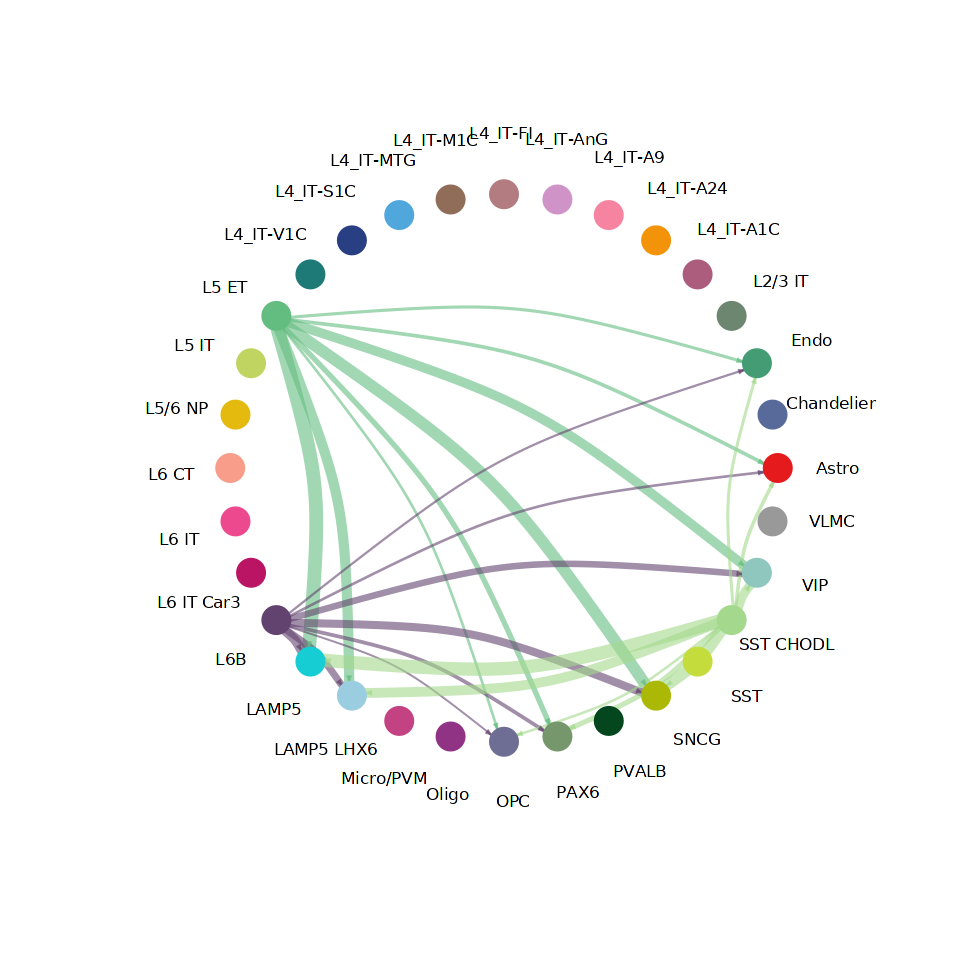

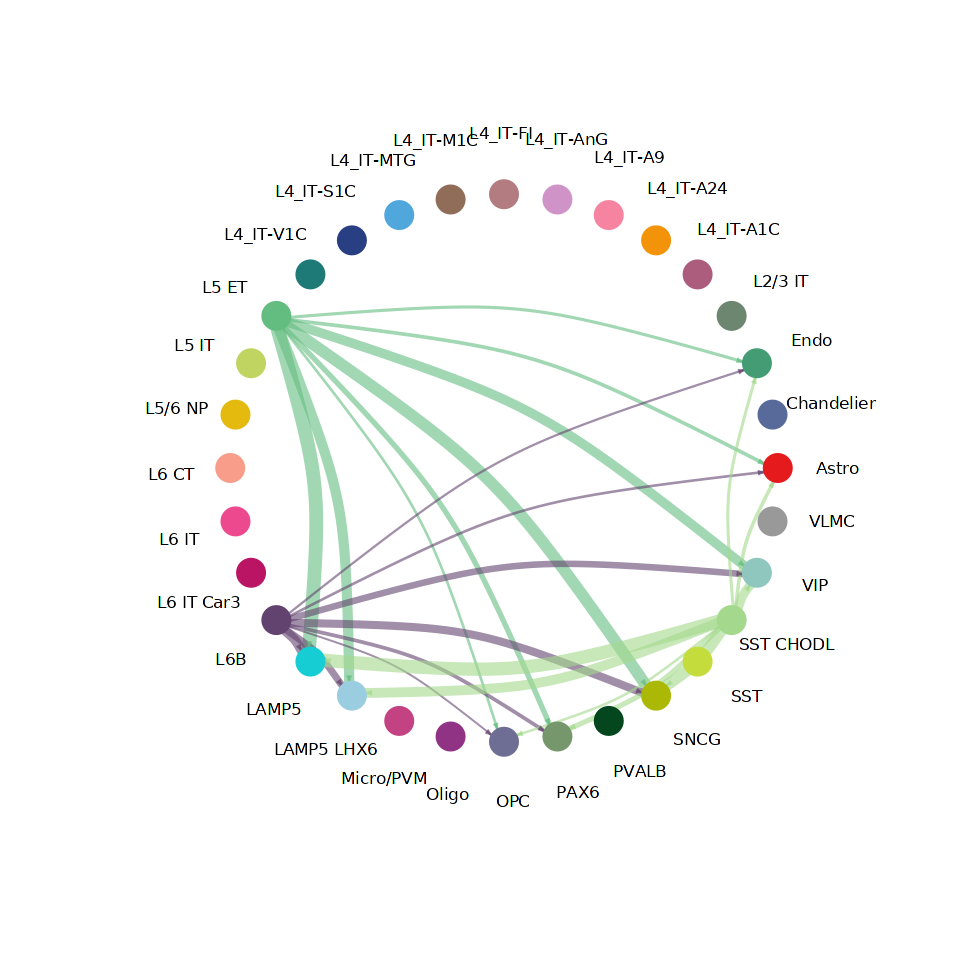

In [10]:
options(repr.plot.width = 8, repr.plot.height = 8)
pathways_show <- c("EGF")
vertex_receiver <- seq(5, 13)
netVisual_aggregate(cellchat, signaling = pathways_show,  vertex.receiver = vertex_receiver)

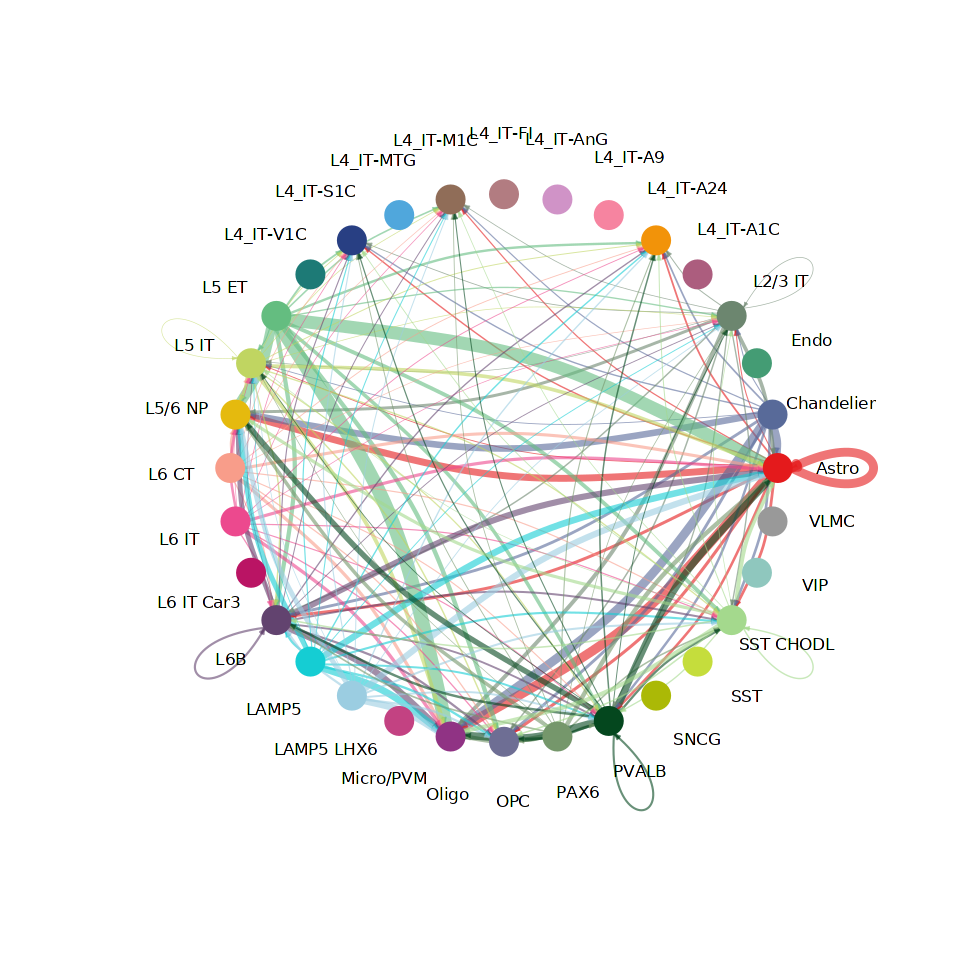

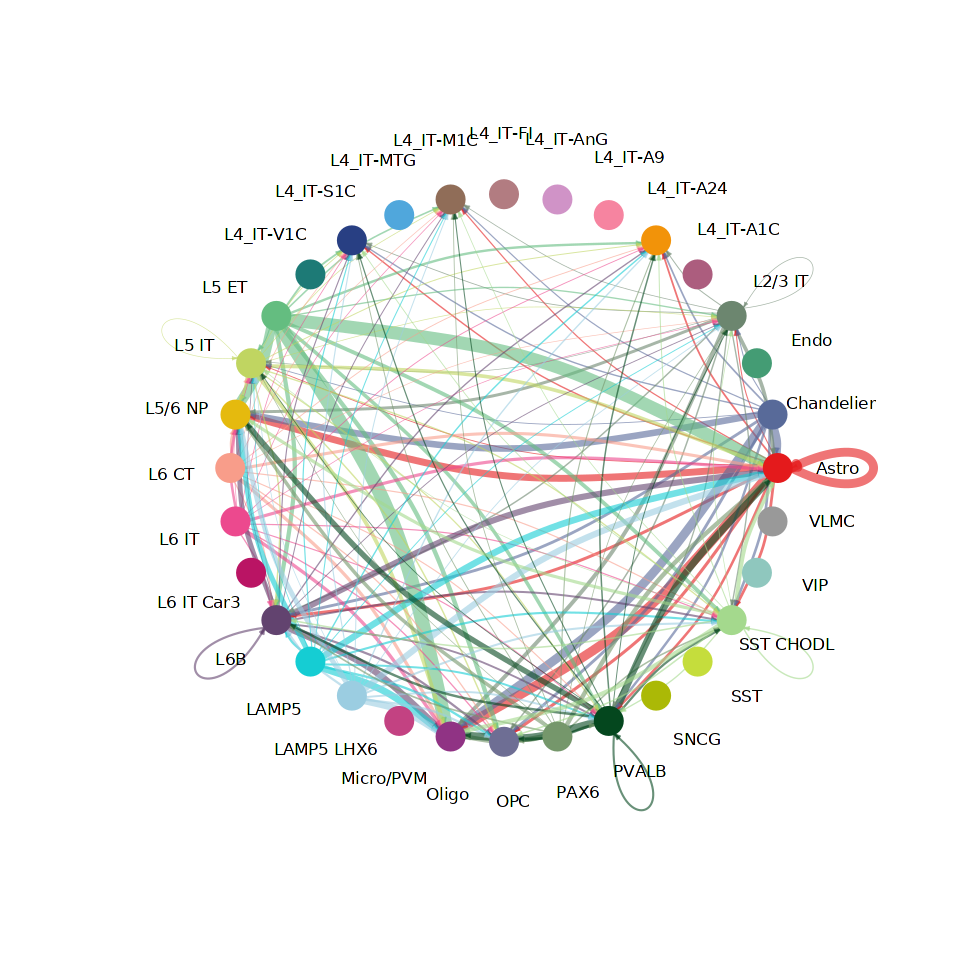

In [11]:
pathways_show <- c("FGF")
vertex_receiver <- seq(5, 13)
netVisual_aggregate(cellchat, signaling = pathways_show,  vertex.receiver = vertex_receiver)

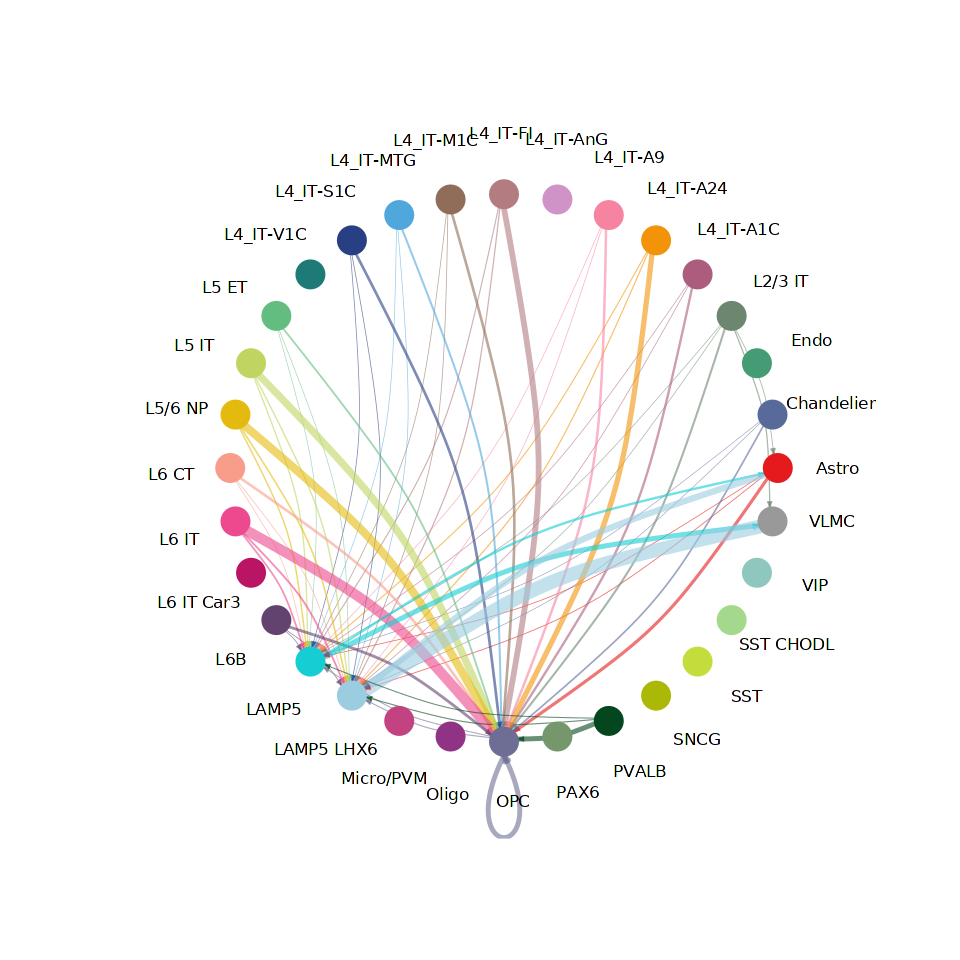

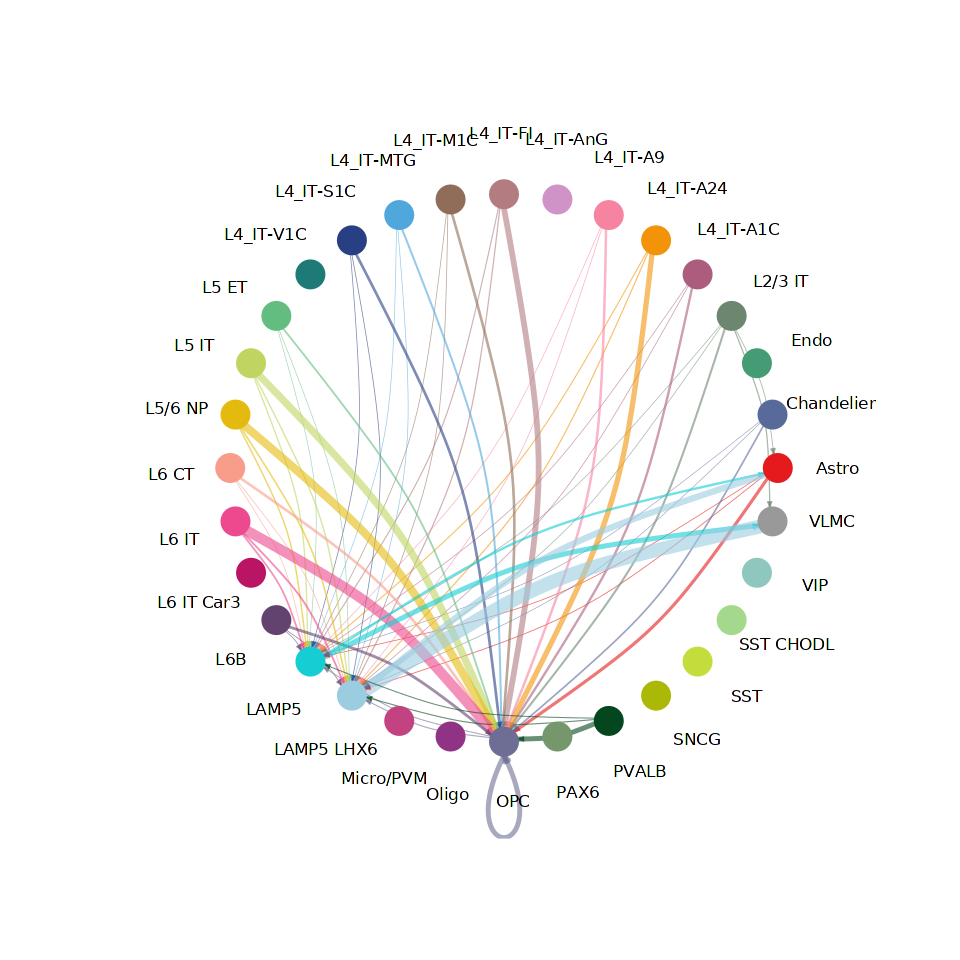

In [12]:
pathways_show <- c("PDGF")
vertex_receiver <- seq(5, 13)
netVisual_aggregate(cellchat, signaling = pathways_show,  vertex.receiver = vertex_receiver)

Do heatmap based on a single object 




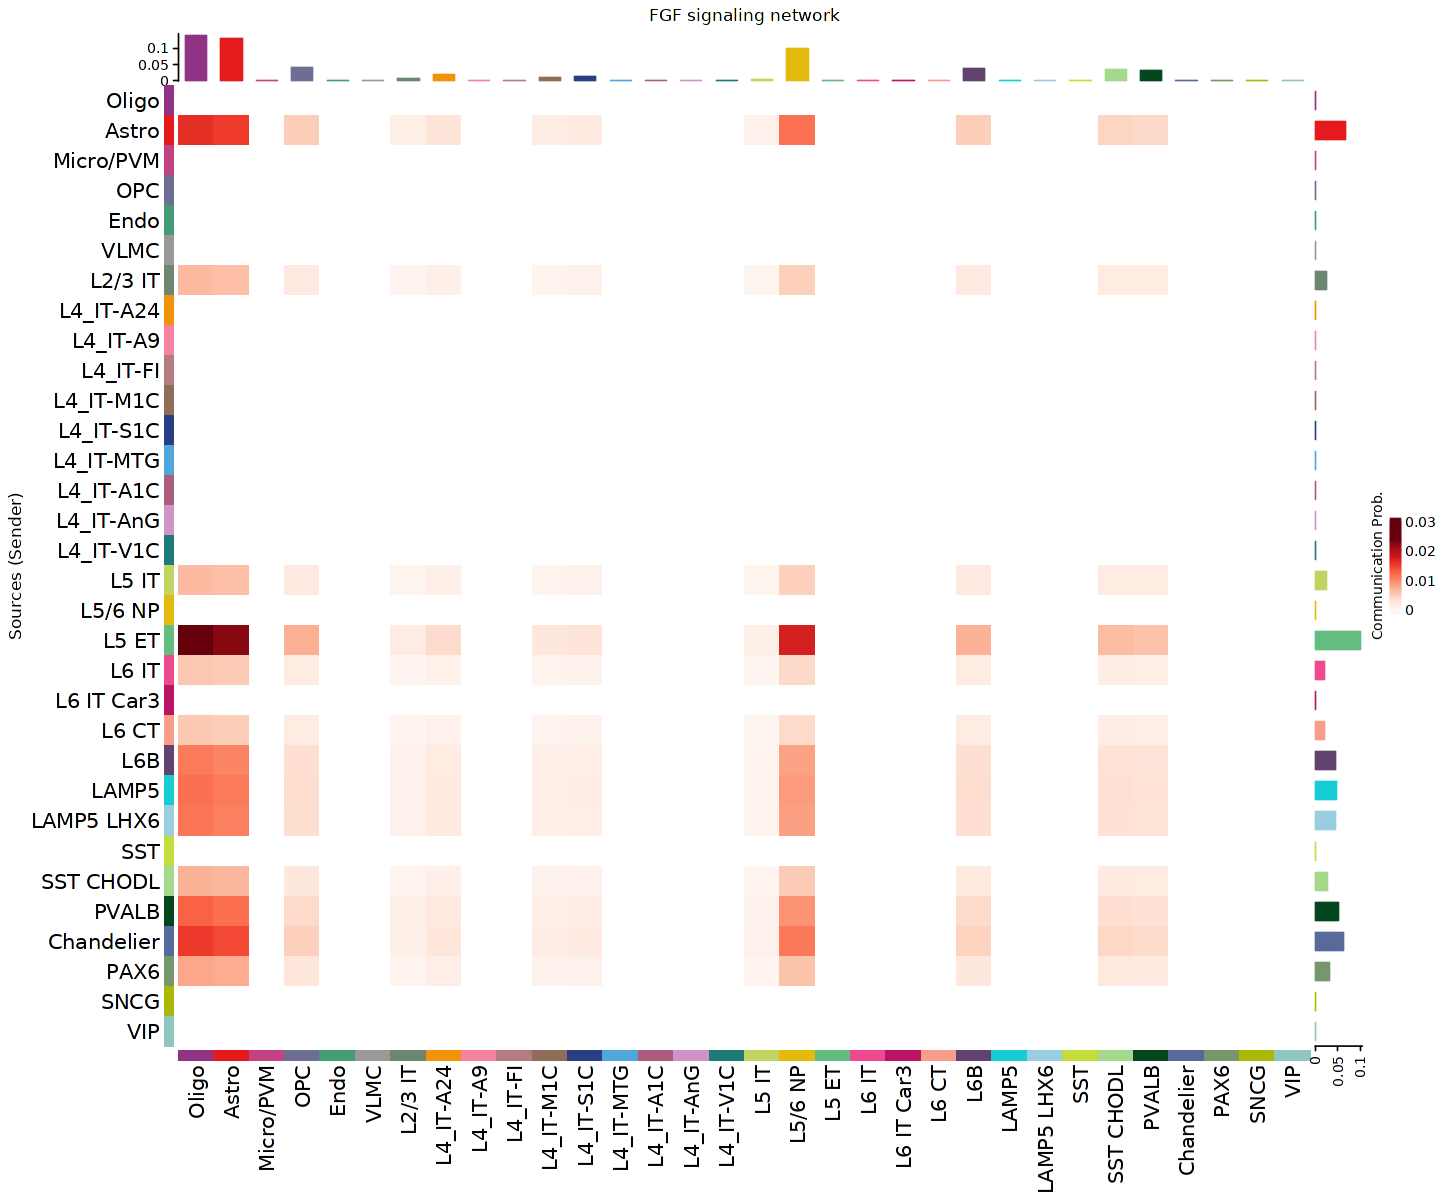

In [13]:
options(repr.plot.width = 12, repr.plot.height = 10)
pathways_show <- c("FGF")
netVisual_heatmap(
    cellchat, signaling = pathways_show, color.heatmap = "Reds",
    font.size = 12, row.show = ident_levels, col.show = ident_levels
)

Do heatmap based on a single object 




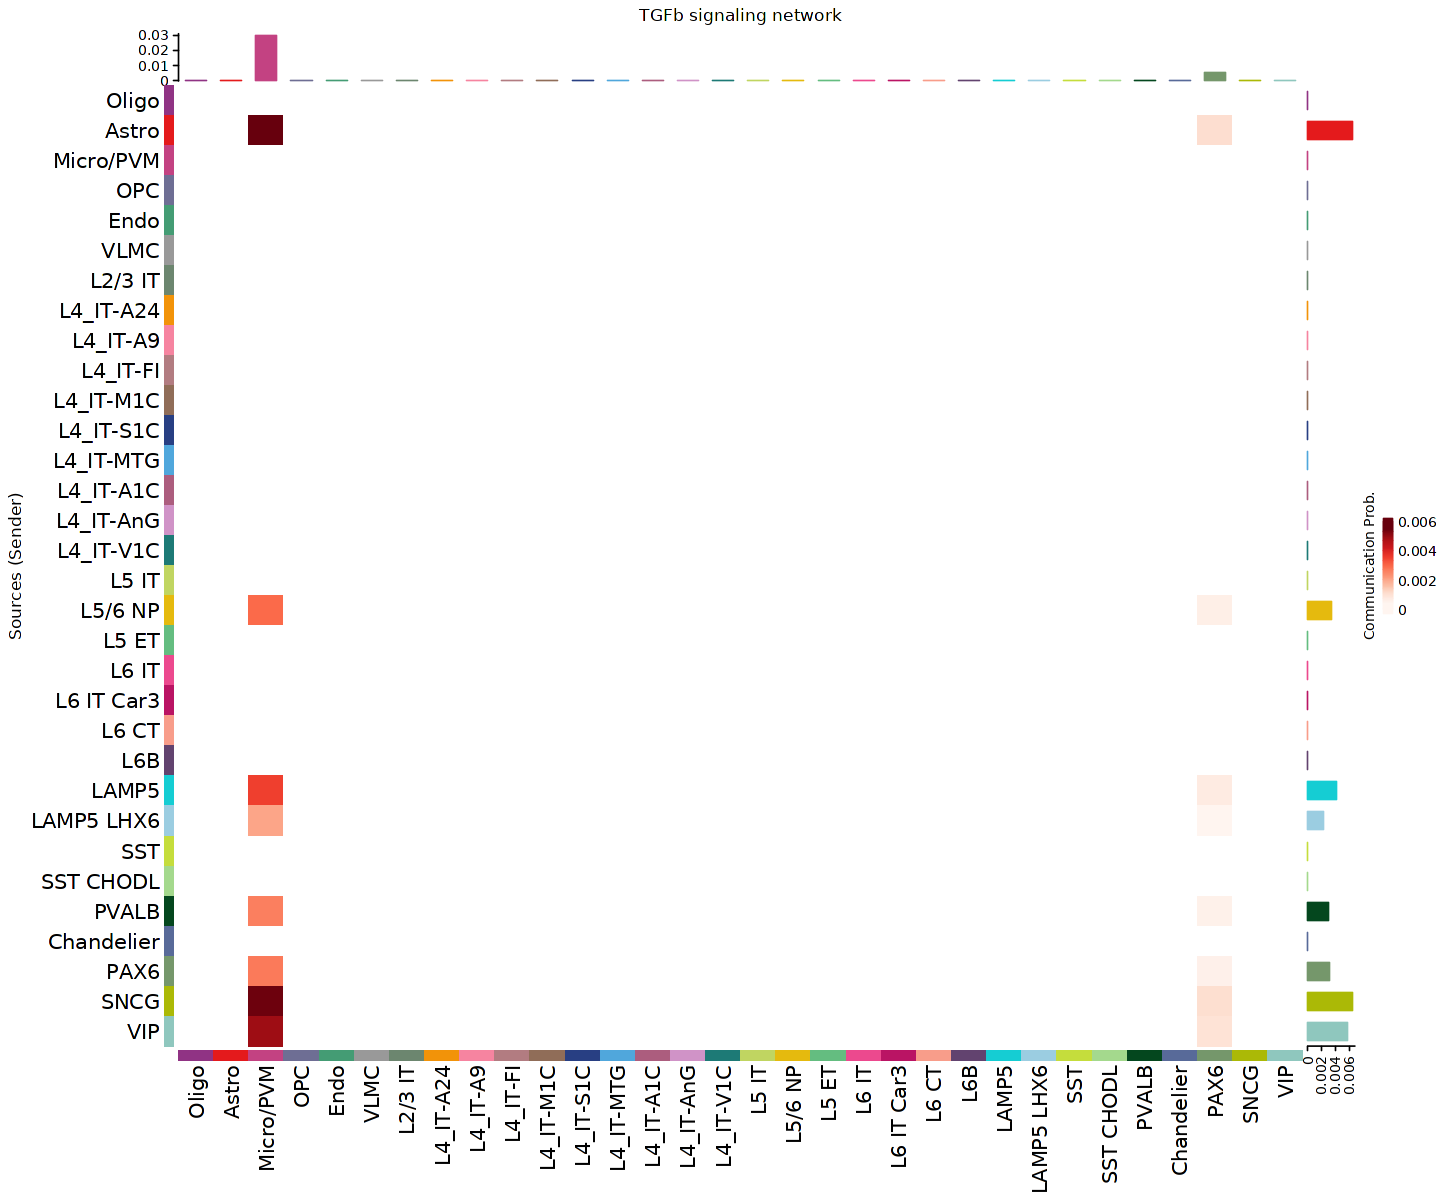

In [14]:
options(repr.plot.width = 12, repr.plot.height = 10)
pathways_show <- c("TGFb")
netVisual_heatmap(
    cellchat, signaling = pathways_show, color.heatmap = "Reds",
    font.size = 12, row.show = ident_levels, col.show = ident_levels
)

Do heatmap based on a single object 




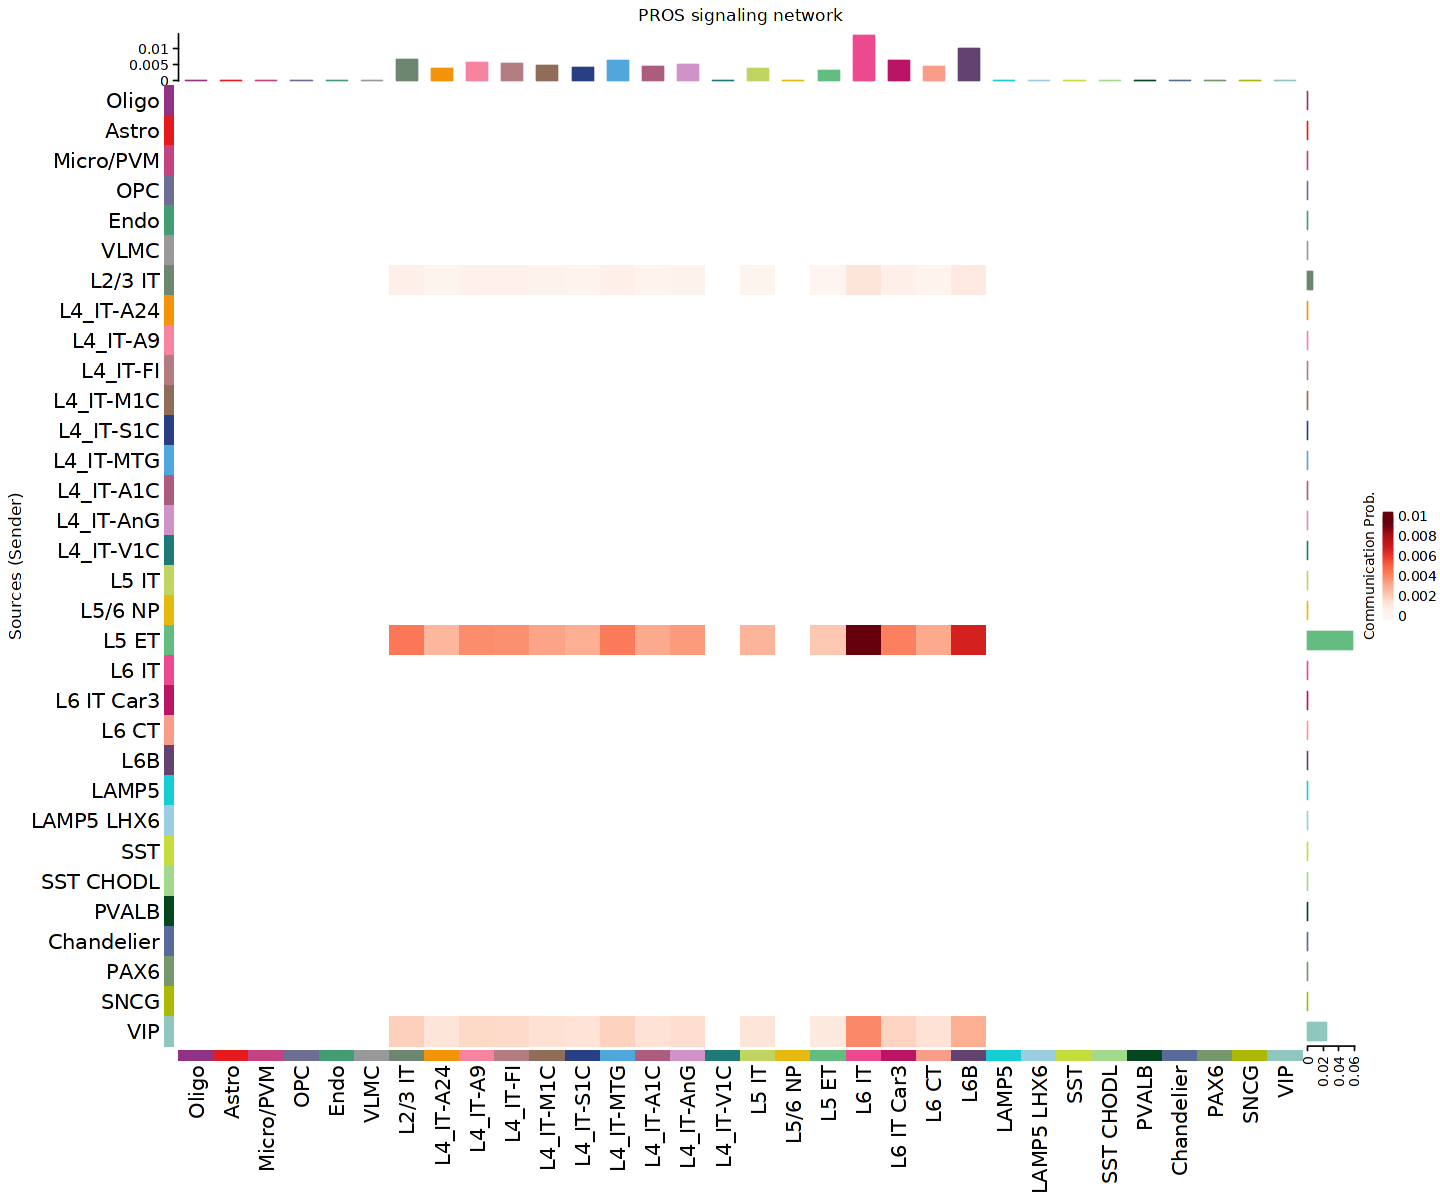

In [15]:
options(repr.plot.width = 12, repr.plot.height = 10)
pathways_show <- c("PROS")
netVisual_heatmap(
    cellchat, signaling = pathways_show, color.heatmap = "Reds",
    font.size = 12, row.show = ident_levels, col.show = ident_levels
)

Do heatmap based on a single object 




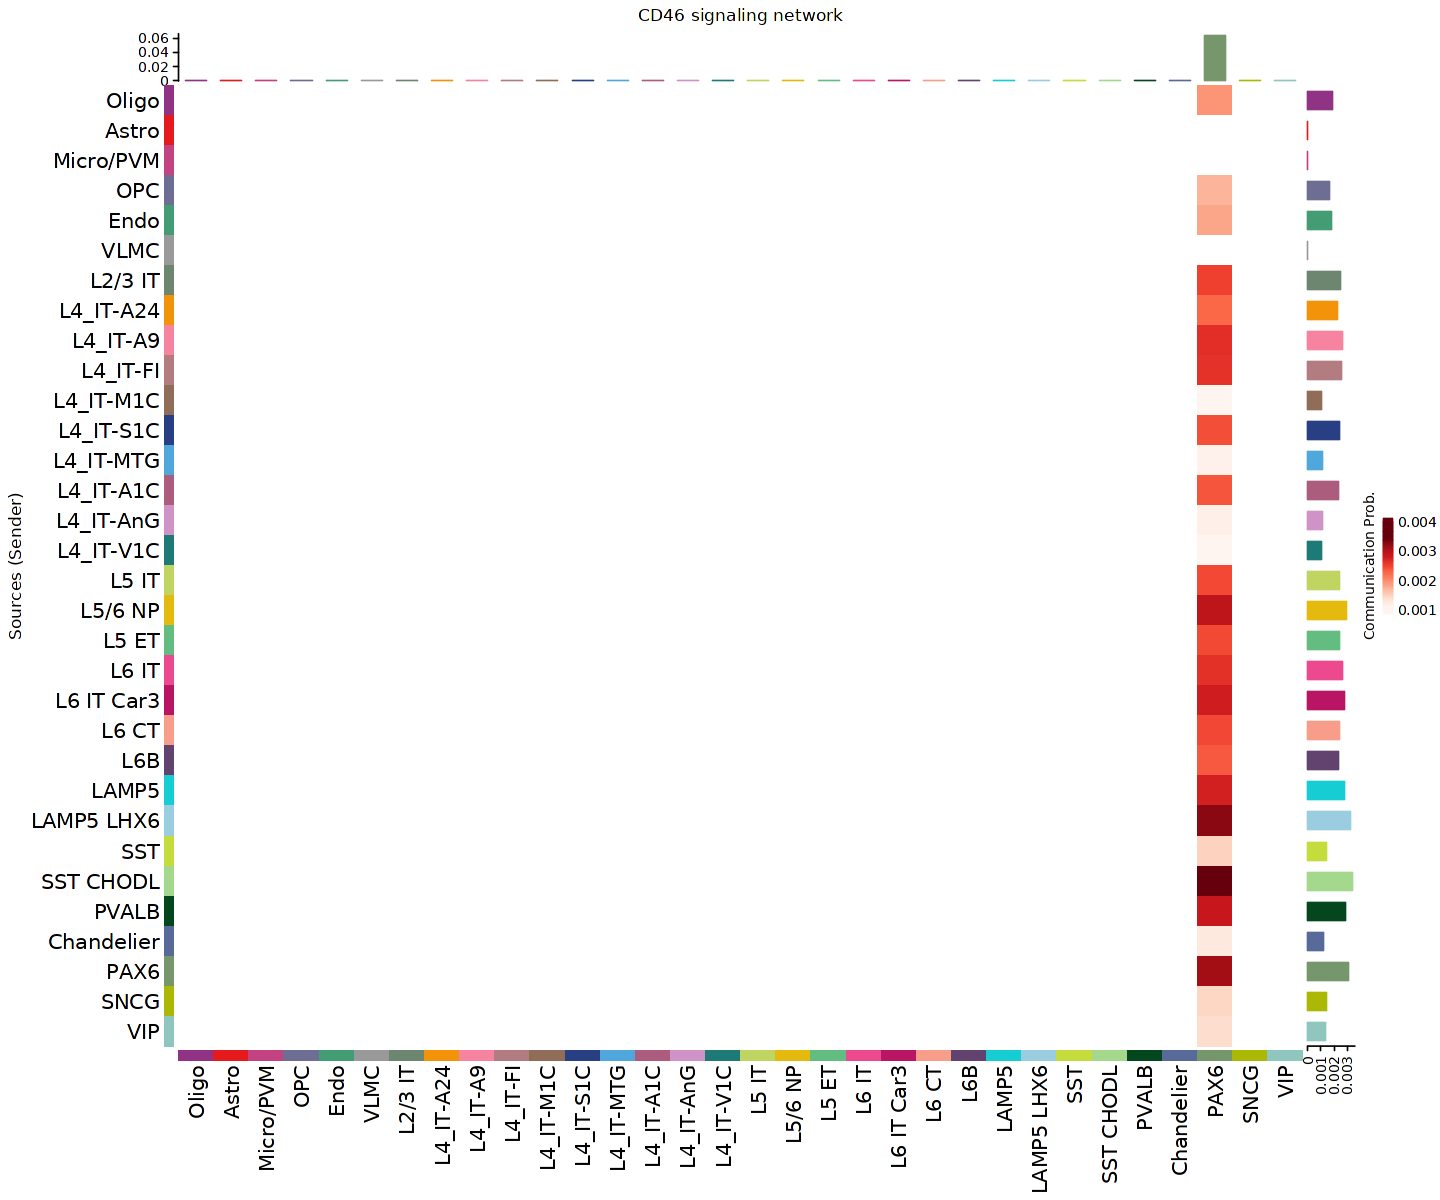

In [16]:
options(repr.plot.width = 12, repr.plot.height = 10)
pathways_show <- c("CD46")
netVisual_heatmap(
    cellchat, signaling = pathways_show, color.heatmap = "Reds",
    font.size = 12, row.show = ident_levels, col.show = ident_levels
)

Do heatmap based on a single object 




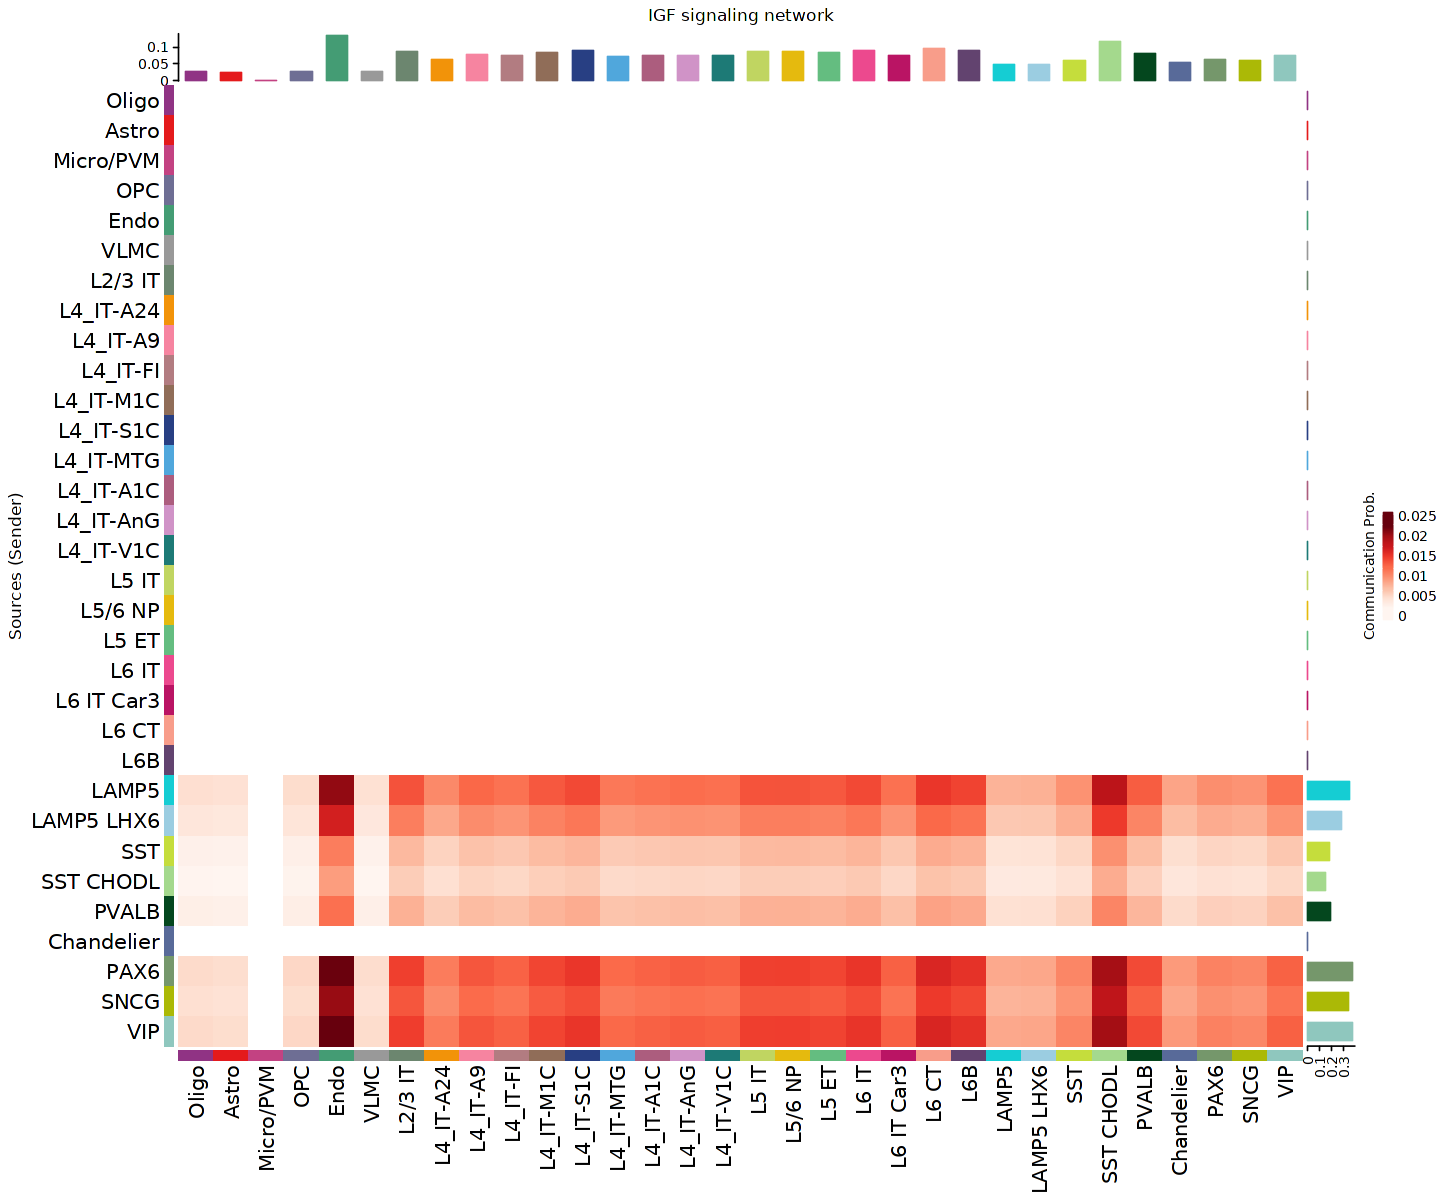

In [17]:
options(repr.plot.width = 12, repr.plot.height = 10)
pathways_show <- c("IGF")
netVisual_heatmap(
    cellchat, signaling = pathways_show, color.heatmap = "Reds",
    font.size = 12, row.show = ident_levels, col.show = ident_levels
)

In [20]:
df_net <- subsetCommunication(cellchat, targets.use = seq(8, 16), slot.name = "netP")

In [22]:
unique(df_net$pathway_name)

[1] "BMP"          "CADM"         "CNTN"         "EPHA"         "LAMININ"     
 [6] "NGL"          "NRXN"         "PTN"          "NCAM"         "FGF"         
[11] "CDH"          "COLLAGEN"     "GAS"          "NECTIN"       "NEGR"        
[16] "FN1"          "CRH"          "VISFATIN"     "PTPRM"        "JAM"         
[21] "NRG"          "PROS"         "SEMA3"        "TENASCIN"     "AGRN"        
[26] "L1CAM"        "MPZ"          "SEMA5"        "SEMA6"        "CCK"         
[31] "PARs"         "SEMA4"        "EPHB"         "THBS"         "HGF"         
[36] "SEMA7"        "NOTCH"        "NT"           "WNT"          "IGF"         
[41] "RELN"         "NPY"          "ncWNT"        "SOMATOSTATIN" "VIP"

Do heatmap based on a single object 




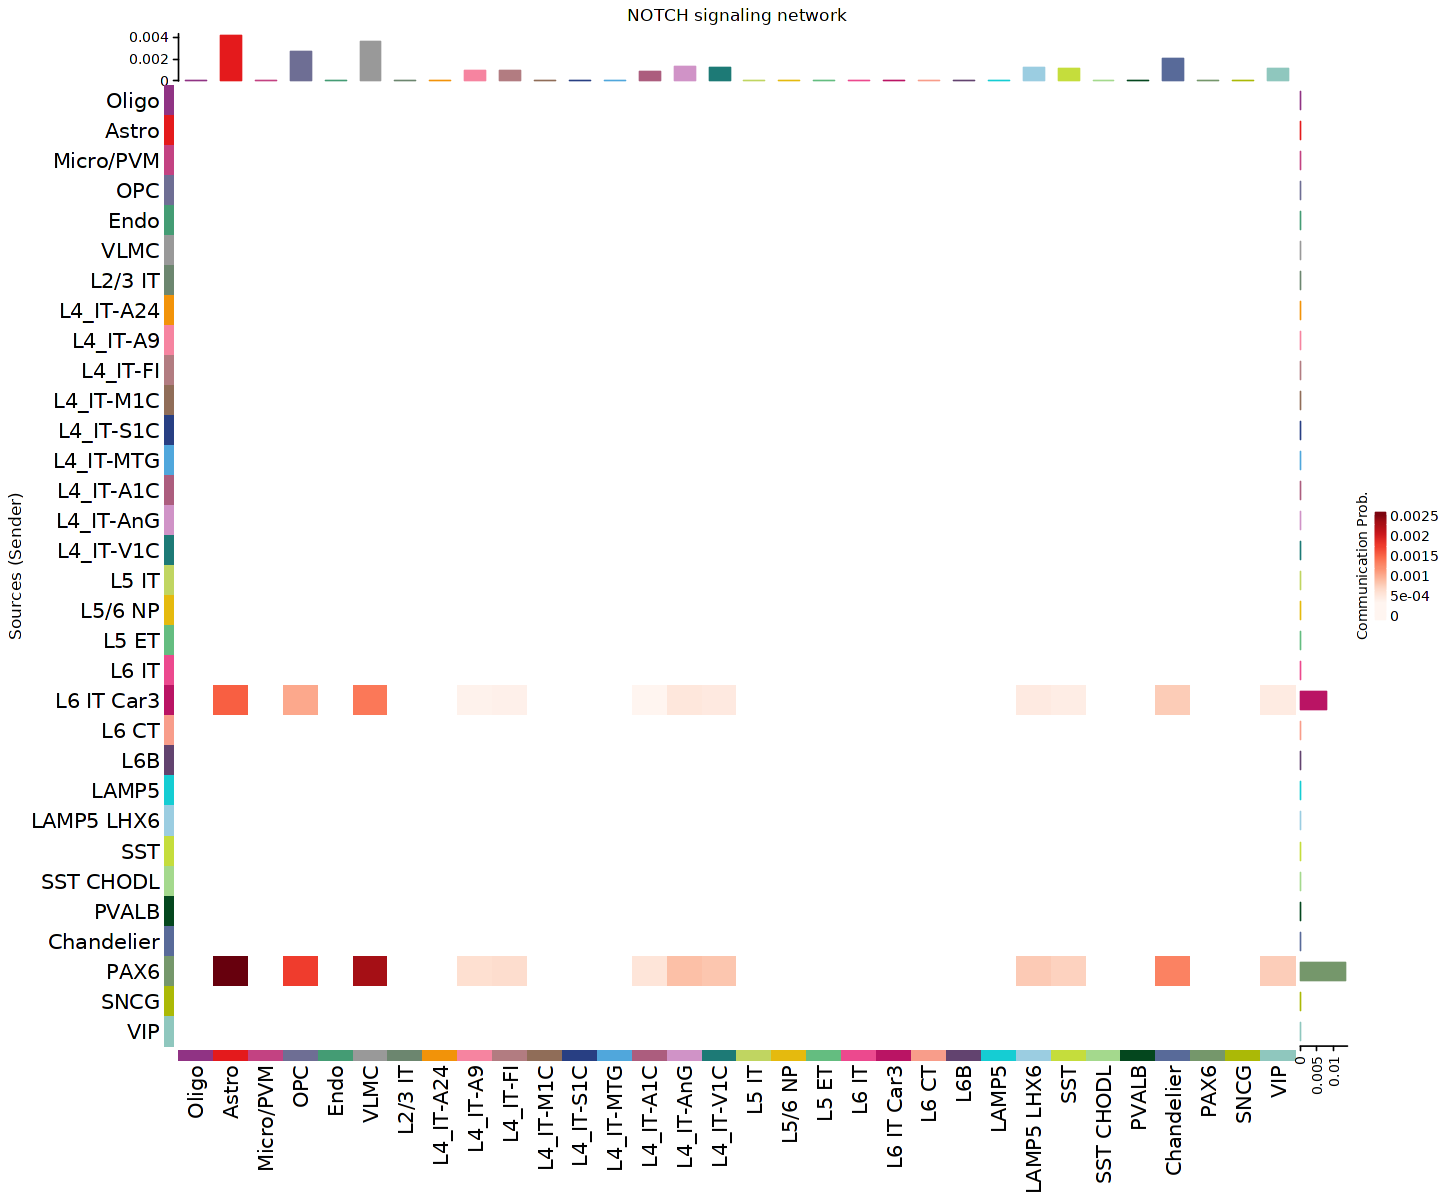

In [23]:
options(repr.plot.width = 12, repr.plot.height = 10)
pathways_show <- c("NOTCH")
netVisual_heatmap(
    cellchat, signaling = pathways_show, color.heatmap = "Reds",
    font.size = 12, row.show = ident_levels, col.show = ident_levels
)

Do heatmap based on a single object 




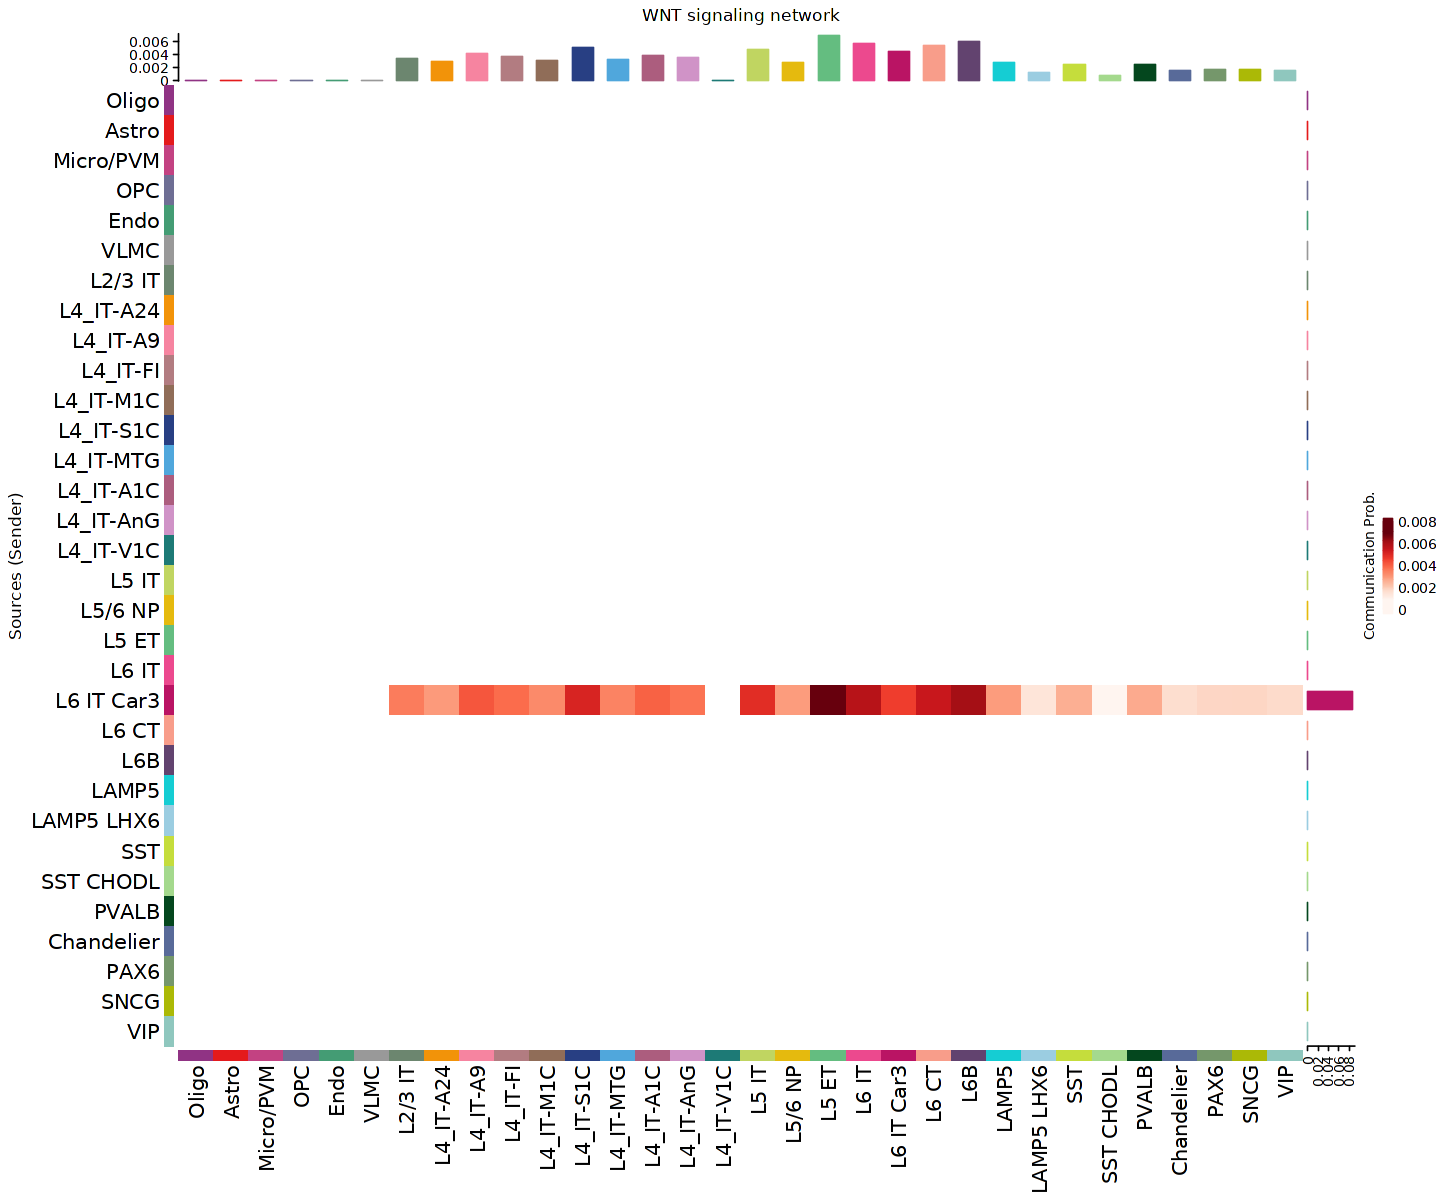

In [24]:
options(repr.plot.width = 12, repr.plot.height = 10)
pathways_show <- c("WNT")
netVisual_heatmap(
    cellchat, signaling = pathways_show, color.heatmap = "Reds",
    font.size = 12, row.show = ident_levels, col.show = ident_levels
)